## Exercise - The 10 Armed Bandit Problem

## Table of Contents
* [Introduction](#Introduction) 
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge) 
  * [Prerequisites](#Prerequisites) 
* [Python Modules](#Python-Modules)
* [Exercises](#Exercises) 
 * [The Bandits](#The-Bandits)
 * [Notation](#Notation)
 * [The epsilon-greedy action selection](#The-epsilon-greedy-action-selection)
 * [Gradient Bandit Algorithm](#Gradient-Bandit-Algorithm)
* [Literature](#Literature) 
* [Licenses](#Licenses) 

## Introduction

In this notebook you will learn the basic principles of reinforcment learning and see how it differs from supervised learning. Classicle supervised learning is purely based on learning a certain task like classification or regression given a set of training variables, features and labels. So while training you already know what to aim for. Reinforcment learning on the other hand is more "learning by doing". So at start you do not know what to aim for but instead you learn based on an action reward system. Each action you perform gives back a reward and your task is it to maximize the reward over time. 

A quite good and easy to understand task to understand this interplay bewteen action and reward is to learn how to play bandit machines or a multi armend bandit machine. Each arm represents a distribution of rewards and your task will it be to learn which arm to choose in order to maximize the reward over many tries.   

## Requirements

### Knowledge

* basic terms: action, reward, value function
* $\epsilon-greedy$ method, incremental implementation

### Prerequisites

To solve this notebook read `SUT18` until chapter 2.4. `SUT18` is the standard literature for reinforcment learning and the basis for this and following notebooks.

### Python Modules

In [3]:
import numpy as np
import types
import matplotlib.pyplot as plt
import time

%matplotlib inline

## Exercises

The following exercises are based on chapter 2.3 and 2.4 in [SUT18]. Although the problem to be solved is way older. In general, it is about using ressources to either:
* acquire knew knowledge ("exploration")
* or to optimize your actions based on existing knowledge ("exploitation").

Imagine you are in a casino seeing ten one armed bandits in front of you.

![internet connection needed. picture with some one armed bandits.](https://upload.wikimedia.org/wikipedia/commons/b/b7/One-Armed_Bandits_at_Stockmen%27s_Hotel%2C_Elko%2C_Nevada_%2883581%29.jpg)



You have a limited number of trials (e.g. 1.000) and at the beginning the only thing you know, is that each bandit gives another reward. The reward might be normally distributed, like in the picture below:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/10_armed_Bandits_errorbarplot.png)

* Choice among k (here 10) different options, or actions.
* After each choice you receive a numerical reward  $R_t$  (from a stationary probability distribution, here normal distributions) depending on the action you selected.
* **Objective:** maximize the expected total reward over some time period, (e.g. over 1000 action selections).

### The Bandits

Before we start to solve our **objective**, we first need to create some bandits.

#### Task 1

Write a function `get_bandit_function` which returns a function `bandit_fct` representing the bandit. `bandit_fct` returns the reward, based on a reward distribution, given for a certain action (using a bandit arm). The means for all 10 `bandit_fct` distributions should be selected from a normal distribution with mean zero and unit variance and all `bandit_fct` distributions are normal distributions with these selected mean values and also unit variance.

<!--
<center>
<figure>
    <img src='https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/10_armed_Bandits.png' height="500" width="550" />
    <figcaption>Figure 2.1 in [SUT18]</figcaption>
</figure>
</center>
-->

In [10]:
np.random.seed(43)
bandit_means = np.random.normal(10,1,10)
bandit_means

array([10.25739993,  9.09151857,  9.62149689,  9.4650844 , 10.85807335,
        9.58699002, 10.49818858, 12.01019925, 11.26286154,  9.56078514])

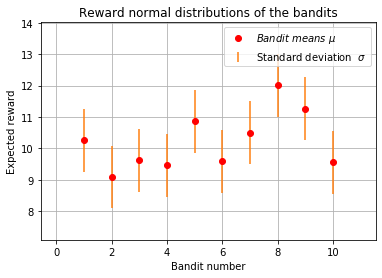

In [11]:
#####################################
######## Code to generate picture ###
#####################################
plt.plot([0,11],[0,0],linestyle='--')
plt.plot(np.arange(10)+1,bandit_means,'ro',label='$Bandit \ means \ \mu$')
plt.errorbar(np.arange(10)+1,bandit_means,yerr=np.ones(10),fmt='none', label='Standard deviation $\ \sigma$')
plt.grid()
plt.title('Reward normal distributions of the bandits')
plt.ylim(min(bandit_means)-2, max(bandit_means)+2)
plt.xlabel('Bandit number')
plt.ylabel('Expected reward')
plt.legend()
plt.show()

### Solution

$$
\DeclareMathOperator*{\argmax}{arg\,max}  % in your preamble
\DeclareMathOperator*{\argmin}{arg\,min}  % in your preamble 
$$

In [13]:
def get_bandit_function(bandit_means, sigma = 1):
    
    def bandit_fct(action):
        return np.random.normal(bandit_means[action], 1, 1)
    
    return bandit_fct

In [13]:
### get a bandit (e.g. lambda function)
bandit_fct = get_bandit_function(bandit_means, sigma=1)
### make a call
print('Test action 4')
print(bandit_fct(3)) # index start at 0 so this is actually action nr.4

Test action 4
[9.11864651]


In [354]:
### This should not throw an exception if your implementation is correct
nb_samples = 100000
action_to_test = 3 

assert isinstance(bandit_fct, types.FunctionType)
print('Test 1 passed')

mean_action_ = np.ndarray(nb_samples)
for i in range(nb_samples):
    mean_action_[i] = bandit_fct(action_to_test)
np.testing.assert_almost_equal(mean_action_.mean(),bandit_means[action_to_test], decimal=2)
print('Test 2 passed')

Test 1 passed
Test 2 passed


### Notation

#### The Problem

On each of an infinite sequence of time steps,  $t=1,2,3,… $,  you choose an action  $A_t$  from  $k$  possibilities, and receive a real-valued reward  $R_t$ 
The reward depends only on the action taken; it is indentically and independently distributed (i.i.d.)

The value then of an arbitrary action  $a$ , denoted  $q_∗(a)$ , is the expected reward given that  action $a$  is selected:

$$
q_*(a)  \dot =  \mathbb E [ R_t | A_t = a], \forall a \in {1,2,\ldots,k}
$$

These values (true values) are unknown. The distribution is unknown.

Nevertheless, you must maximize your total reward.

You must both try actions to learn their values (explore), and prefer those that appear best (exploit)

#### Exploration / Exploitation Dilemma

Suppose you form estimates (action value estimates):

$$
Q_t(a) \approx q_∗(a) \quad \forall a
$$

Define the greedy action at time  $t$  as

$$
\DeclareMathOperator*{\argmax}{arg\,max}  % in your preamble
\DeclareMathOperator*{\argmin}{arg\,min}  % in your preamble 
$$

$$
A^∗_t := \argmax_a Q_t(a)
$$

* If  $A_t=A^∗_t$  then you are exploiting.

* If  $A_t \neq A^∗_t$  then you are exploring.

You can’t do both, but you need to do both

You can never stop exploring, but maybe you should explore less with time. Or maybe not.


#### Action Value Methods

Methods that learn Action-Value estimates and nothing else.

For example, estimate action-values as sample averages:

$$
Q_t(a) \dot{=} \frac{\text{sum of rewards when a taken prior to } t}{\text{number of times a taken prior to } t} =  \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_{i=a}}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_{i=a}}}
$$ 
 
The sample-average estimates converge to true values. If the action is taken an infinite number of times

$$
\lim_{N_t(a) \rightarrow \infty} Q_t(a) = q_*(a)
$$

with $N_t(a)$, the number of times action  $a$  has been taken by time  $t$.

#### Averaging

To calculate the estimate $Q_{n_a}(a)$ of an action $a$, we calculate the average after $n_a+1$ rewards:

$$
Q_{n_a}(a) \dot{=} \frac{R_1 + R_2 + \ldots + R_{n_a+1}}{n_a-1}
$$

This would require us to store all rewards. To save memory, we can calculate the so called running average, only storing the latest $Q_{n_a}(a)$ and $n_a$:

$$
Q_{n_a+1}(a) \dot{=} Q_{n_a}(a) + \frac{1}{n_a} [ R_{n_a} - Q_{n_a}(a) ]
$$

### The epsilon-greedy action selection

In greedy action selection, you always exploit.

In  $\epsilon$ -greedy, you are usually greedy, but with probability  $\epsilon$  you instead pick an action at random (also possibly the greedy action again).

This is perhaps the simplest way to balance exploration and exploitation


#### Task 2 

Implement the action-value method with the incremental implementation, $\epsilon$-greedy algorithm, for the 10 armend bandit problem.

a) implement the update rule for the action-values Q, `update_Qs(action, reward, Qs, Ns)`

b) write a function that plays a bandit and returns Q values, rewards and actions done
    `play_a_bandit(epsilon, bandit_fct, optimistic=0., nb_steps = 1000, nb_arms=10):`

c) to "analyze" your algorithm perform multiple runs, always using a new 10 armed bandit, and calculate the average reward and percentage of optimal choices for each step over these multiple runs, visualize your results for different $\epsilon$ values. Your plots should look like the following:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/10_armed_Bandits_avg_reward.png)
![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/10_armed_Bandits_optimal_action.png)


**Hint:** 

For the last part use at least 500 runs for nicely shaped plots


### Solution a)

In [355]:
def update_Qs(action, reward, Qs, Ns):
    #reward is a scalar
    Ns[action] += 1 
    Qs[action] = Qs[action] + 1/Ns[action]*(reward - Qs[action])
    return None

In [356]:
### Needed for the next cell to validate your implementation
def init_Ns_Qs_Rs():
    np.random.seed(44)
    Ns = [0 for i in range(10)]
    Qs = [0 for i in range(10)]
    Rs = [np.random.randint(0,10, size=np.random.randint(0,10, size=1)) for i in range(10)]
    return Ns, Qs, Rs

Ns, Qs, Rs = init_Ns_Qs_Rs()
print(Ns)
print(Qs)
print(Rs)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([3, 1, 3, 0]), array([3, 8, 7, 7]), array([9, 3, 7, 3, 3, 6]), array([4, 5, 9, 1, 8]), array([4, 5, 3, 0, 4, 9, 2]), array([8, 6, 2, 0, 3, 4, 8, 3]), array([2, 1]), array([2, 9]), array([1, 8, 9, 4, 2, 4, 6, 7]), array([5, 6, 2, 5, 1])]


In [357]:
### This cell should not throw an exception

Ns, Qs, Rs = init_Ns_Qs_Rs()

for action, rewards in enumerate(Rs):
    print('action: ', action, 'rewards: ', rewards)
    for r in rewards:
        update_Qs(action, r, Qs, Ns)

print(Ns)
print(Qs)
        
assert Ns[0] is 4
assert Ns[1] is 4
assert Ns[2] is 6
assert Ns[3] is 5
assert Ns[4] is 7
assert Ns[5] is 8
assert Ns[6] is 2
assert Ns[7] is 2
assert Ns[8] is 8
assert Ns[9] is 5
assert Qs[0] == 1.75
assert Qs[1] == 6.25
assert Qs[2] ==(5.166666666666667)
assert Qs[3] == 5.4
assert Qs[4] == 3.8571428571428577
assert Qs[5] == 4.249999999999999
assert Qs[6] == 1.5
assert Qs[7] == 5.5
assert Qs[8] == 5.125
assert Qs[9] == 3.8


action:  0 rewards:  [3 1 3 0]
action:  1 rewards:  [3 8 7 7]
action:  2 rewards:  [9 3 7 3 3 6]
action:  3 rewards:  [4 5 9 1 8]
action:  4 rewards:  [4 5 3 0 4 9 2]
action:  5 rewards:  [8 6 2 0 3 4 8 3]
action:  6 rewards:  [2 1]
action:  7 rewards:  [2 9]
action:  8 rewards:  [1 8 9 4 2 4 6 7]
action:  9 rewards:  [5 6 2 5 1]
[4, 4, 6, 5, 7, 8, 2, 2, 8, 5]
[1.75, 6.25, 5.166666666666667, 5.4, 3.8571428571428577, 4.249999999999999, 1.5, 5.5, 5.125, 3.8]


### Solution b)

In [358]:
def play_a_bandit(epsilon, bandit_fct, optimistic=0., nb_steps = 1000, nb_arms=10):
    """    
    Parameters
    ----------
    epsilon : float
        epsilon: probability of chosing a random action (exploration)
        
    optimistic: float
        Initial value for the Q-values (for all action)
        
    nb_steps: int
        Number of steps. How often the bandit is played
        
    """

    #initialization
    Qs = [optimistic for i in range(nb_arms)]
    Ns = [0 for i in range(nb_arms)]
    actions, rewards = [],[]
   
    #play 
    for i in range(nb_steps):
        
        #epsilon-greedy policy
        if np.random.random() < epsilon: #exploration
            next_action = np.random.randint(nb_arms)
        else: #exploitation
            next_action = np.argmax(Qs)
        
        reward = bandit_fct(next_action)
        update_Qs(next_action, reward, Qs, Ns)
        actions.append(next_action)
        rewards.append(reward)

        
    return Qs, rewards, actions


### Solution c)

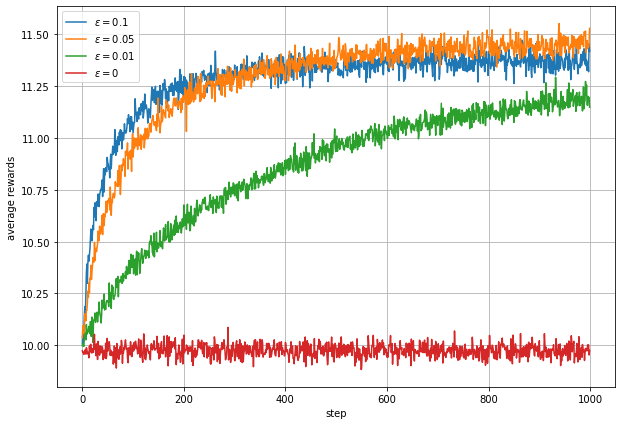

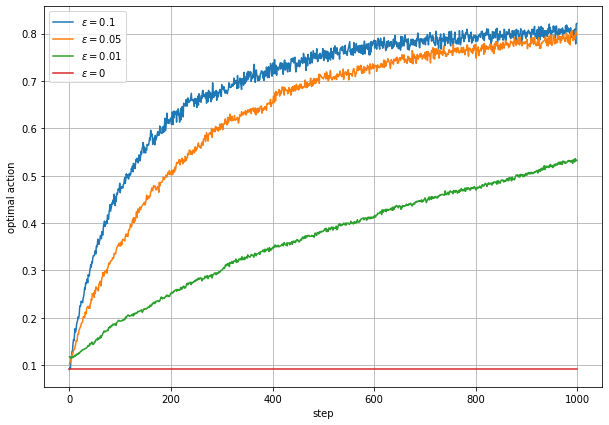

In [196]:
######################
### Your code here ###
######################
epsilon_list = [0.1, 0.05, 0.01, 0]
nb_steps     = 1000
nb_runs      = 1000
nb_arms      = 10
fig1, ax1 = plt.subplots(figsize=(10,7))
fig2, ax2 = plt.subplots(figsize=(10,7))

for epsilon in epsilon_list:
    actions  = np.zeros((nb_runs, nb_steps))
    rewards     = np.zeros((nb_runs, nb_steps))
    optimal_action = np.zeros(nb_steps)
    standard_action  = np.zeros(nb_runs)
    
    for run in range(nb_runs):
        #generate new 10 one-armed bandits
        bandit_means = np.random.normal(10, 1, nb_arms)
        bandit_fct   = get_bandit_function(bandit_means, sigma=1)       
        Qs, rewards[run, :], actions[run, :] = play_a_bandit(epsilon, bandit_fct, 0., nb_steps, nb_arms)
        standard_action[run]  = np.argmax(bandit_means)

    #count the numbers of optimal action
    for i in range(nb_runs):
        for j in range(nb_steps):
            if actions[i, j] == standard_action[i]:
                optimal_action[j] += 1

    average_rewards = np.average(rewards, axis=0)
    ax1.plot(np.arange(nb_steps), average_rewards, label=r'$\epsilon={}$'.format(epsilon))
    
    ax2.plot(np.arange(nb_steps), optimal_action*1.0/nb_runs, label=r'$\epsilon={}$'.format(epsilon))
        
ax1.legend()
ax1.grid()
ax1.set_xlabel('step')
ax1.set_ylabel('average rewards')

ax2.legend()
ax2.grid()
ax2.set_xlabel('step')
ax2.set_ylabel('optimal action')

plt.show()        

### Gradient Bandit Algorithm

Another approach to solve the Bandit problem is the `Gradient Bandit Algorithm` presented in chapter 2.8 [SUT18]

Instead of selecting only the best considdered bandit with probability $1 - \epsilon$ or uniformly any bandit with probability $\epsilon$, we can assign a preference $H_t(a)$ for each bandit, which we dynamically adjust after each time step $t$.

These $H_t(a)$ are then used to computed the probabilities which action (bandit) $A_t$ to chose at current time step $t$, with the softmax function:

$$
P(A_t = a) = \frac{\exp(H_t(a))}{\sum^k_{b=1}\exp(H_t(b))} = \pi_t(a)
$$

After we receive our reward $R_t$ with action $A_t$ we update $H_t(A_t)$:

$$
H_{t+1}(A_t)= H_t(A_t) + \alpha(R_t - \bar R_t)(1-\pi_t(At))
$$

and all other actions $a$ we did not chose with:

$$
H_{t+1}(a)= H_t(A_t) - \alpha(R_t - \bar R_t)(1-\pi_t(a))
$$

$\bar R_t$ is the overall average reward so far and can be used as a baseline.

Initially at $t=0$ all $H_{t=0}(a)$ are $0$.



#### Task 3

Implement the `Gradient Bandit Algorithm` for the 10 armend bandit problem. The steps taken here are fairly equivalent to task 2.

* implement the `softmax` function for the numerical preference `H`
* implement the update rule for the preference `H`
* write a function `play_bandit_grad` which plays the bandit machine according to the `Gradient Bandit Algorithm`
* write a function `get_percentage_optimal_action` that returns the percentage of optimal actions taken for each step, test different alpha's with and without baseline ($\bar R_t$ is not updated and  stays $0$). The plot should show, that using a baseline has a significant impact over not using the baseline:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/oliver/10_armed_Bandits_gradient.png)



**Tip:** for the last part use at least 100 runs for nicely shaped plots


### Solution

In [4]:
def softmax(H):
    h = H - np.max(H)
    exp_h = np.exp(h)
    return exp_h/np.sum(exp_h)

In [5]:
# def update_H(action, R_avg, R_t, H, alpha=0.1):
#     """    
#     Parameters
#     ----------
    
#     action: integer
#         current action taken
        
#     R_avg: float
#         average reward until time step t
        
#     R_t: float
#         curent reward at time step t
    
#     H: float
#         numerical preference
    
#     alpha: float
#         step size parameter     
   
#     """
#     Pi_t = softmax(H)
    
#     a = action
#     H[a] = H[a] + alpha*(R_t-R_avg)*(1-Pi_t[a])
    
#     H[:a] = H[:a] - alpha*(R_t-R_avg)*Pi_t[:a]
#     H[a+1:] = H[a+1:] - alpha*(R_t-R_avg)*Pi_t[a+1:]
    

In [6]:
#nb_arms = 10
#bandits_generation_mean = 4.
#bandits_means = np.random.randn(nb_arms) + bandits_generation_mean
#optimal_action = np.argmax(bandits_means)

In [7]:
# def play_bandit_grad(optimal_action, nb_steps=1000, 
#                      bandit_fct=bandit_fct,
#                     use_R_avg_baseline=True, alpha=0.1):
#     """    
#     Parameters
#     ----------
    
#     optimal_action: integer
#         optimal action which can be taken
    
#     nb_steps: integer
#         number of steps a bandit is played
    
#     bandit_fct:
#         function that simulates a bandit play
    
#     use_R_avg_baseline: bool
#         is true R_avg is updated at each steps according to moving 
#         averages
    
#      alpha: float
#         step size parameter
    
#     """
#     nb_arms = 10
#     H=np.zeros(nb_arms)
#     R_avg = 0.
#     is_optimal_action = np.zeros(nb_steps) # history of optimal steps taken
    
#     for step in range(1, nb_steps):
#         next_action = np.random.choice(nb_arms, p=softmax(H))
#         reward = bandit_fct(next_action)
        
#         #update R_avg
#         if use_R_avg_baseline is True:
#             R_avg = R_avg + 1.0/step*(reward - R_avg)
            
#         update_H(next_action, R_avg, reward, H, alpha)
        
#         if next_action == optimal_action:
#             is_optimal_action[step] = 1
        
#     return H, R_avg, is_optimal_action


In [8]:
# nb_steps=1000

# def get_percentage_optimal_action(n=100, alpha=0.1, use_R_avg_baseline=True):

    
#     """    
#     Parameters
#     ----------
    
#     n: integer
#         number of runs, how many bandit machines are played
    
#     alpha: float
#         step size parameter
    
#     use_R_avg_baseline: bool
#         is true R_avg is updated at each steps according to moving 
#         averages
    
#     """
#     #generate new 10 one-armed bandits
#     bandit_fct = get_bandit_function(bandit_means, sigma=1) 

#     percentage_optimal_action=np.zeros(nb_steps)

#     for i in range(n):
#         bandits_generation_mean = 4.
#         bandits_means = np.random.randn(nb_arms) + bandits_generation_mean
#         optimal_action = np.argmax(bandits_means)
#         _, _, is_optimal_action = play_bandit_grad(optimal_action, nb_steps, bandit_fct, use_R_avg_baseline, alpha)
#         percentage_optimal_action += is_optimal_action
#         break
    
#     return percentage_optimal_action*1.0/n


In [9]:
# percentage_optimal_action_a01 = get_percentage_optimal_action(n=50, alpha=0.1)
# #percentage_optimal_action_a01_no_baseline = get_percentage_optimal_action(n=100, alpha=0.1, use_R_avg_baseline=False)
# #percentage_optimal_action_a04 = get_percentage_optimal_action(n=100, alpha=0.4)
# percentage_optimal_action_a04_no_baseline = get_percentage_optimal_action(n=100, alpha=0.4, use_R_avg_baseline=False)

In [10]:
# plt.figure(figsize=(10,7))
# plt.plot(np.arange(nb_steps), percentage_optimal_action_a01, label=r'$\alpha=0.1$')
# #plt.plot(np.arange(nb_steps), percentage_optimal_action_a04, label=r'$\alpha=0.4$')
# #plt.plot(np.arange(nb_steps), percentage_optimal_action_a01_no_baseline, label=r'$\alpha=0.1$, without baseline')
# #plt.plot(np.arange(nb_steps), percentage_optimal_action_a04_no_baseline, label=r'$\alpha=0.4$, without baseline')
# plt.legend(loc=4)
# plt.xlabel("steps")
# plt.ylabel("% optimal action")
# plt.grid()
# plt.show()


Something wrong in the old version( all codes are commented)

In [18]:
def gradient_bandit(nb_runs, nb_steps, nb_arms, alpha, is_baseline):
    
    actions = np.zeros((nb_runs, nb_steps), dtype=int)
    rewards = np.zeros((nb_runs, nb_steps), dtype=int)
    is_optimal = np.zeros(nb_runs)
    
    for run in range(nb_runs):
        bandit_generation_mean = 10.
        bandit_means = np.random.randn(nb_arms) + bandit_generation_mean
        optimal_action = np.argmax(bandit_means)
        bandit_fct = get_bandit_function(bandit_means, 1)
        H = np.zeros(nb_arms)
        is_optimal[run] = optimal_action
        Ns = np.ones(nb_arms)
        R_avg = 0

        for step in range(1, nb_steps):
            Pi_t = softmax(H)
            actions[run, step] = np.random.choice(nb_arms, p=Pi_t)
            rewards[run, step] = bandit_fct(int(actions[run, step]))

            if is_baseline is True:
                R_avg = R_avg + 1.0/step*(rewards[run, step] - R_avg)
            else:
                R_avg = 0

            a = int(actions[run, step])
            H[a] = H[a] + alpha*(rewards[run, step]-R_avg)*(1-Pi_t[a])
            H[:a] = H[:a] - alpha*(rewards[run, step]-R_avg)*Pi_t[:a]
            H[a+1:] = H[a+1:] - alpha*(rewards[run, step]-R_avg)*Pi_t[a+1:]

    average_rewards = np.average(rewards, axis=0)
    percentage_opt  = np.zeros(nb_steps)
    for i in range(nb_runs):
        for j in range(nb_steps):
            if actions[i, j] == is_optimal[i]:
                    percentage_opt[j] += 1
    if is_baseline is False:
        Label = r'$\alpha={}$'.format(alpha)+'without baseline'
    else:
        Label = r'$\alpha={}$'.format(alpha)
        
    ax1.plot(np.arange(nb_steps-1), average_rewards[1:], label=Label)

    ax2.plot(np.arange(nb_steps), percentage_opt*1.0/nb_runs, label=Label)



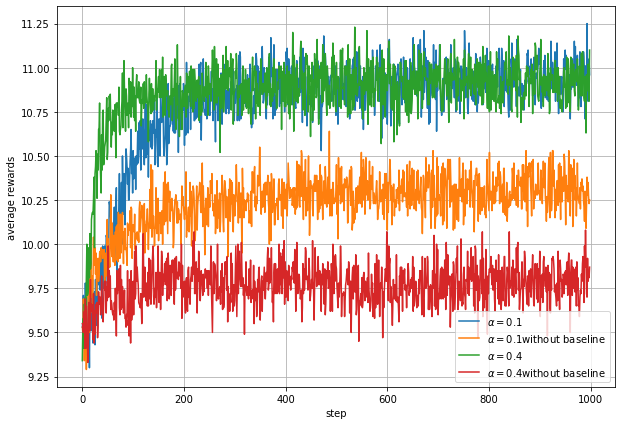

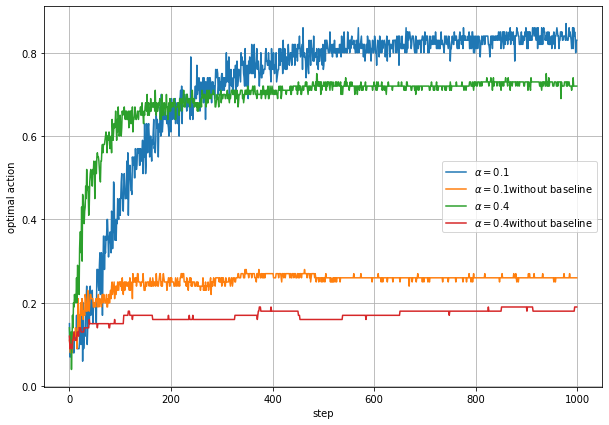

In [19]:
fig1, ax1 = plt.subplots(figsize=(10,7))
fig2, ax2 = plt.subplots(figsize=(10,7))
    
nb_runs = 100
nb_arms = 10
nb_steps = 1000
actions = np.zeros((nb_runs, nb_steps), dtype=int)
rewards = np.zeros((nb_runs, nb_steps), dtype=int)
is_optimal = np.zeros(nb_runs)

gradient_bandit(nb_runs, nb_steps, nb_arms, alpha=0.1, is_baseline=True)
gradient_bandit(nb_runs, nb_steps, nb_arms, alpha=0.1, is_baseline=False)
gradient_bandit(nb_runs, nb_steps, nb_arms, alpha=0.4, is_baseline=True)
gradient_bandit(nb_runs, nb_steps, nb_arms, alpha=0.4, is_baseline=False)

ax1.legend()
ax1.grid()
ax1.set_xlabel('step')
ax1.set_ylabel('average rewards')

ax2.legend()
ax2.grid()
ax2.set_xlabel('step')
ax2.set_ylabel('optimal action')

plt.show()   

## Literature


<table>
    <tr>
        <td>
            <a name="SUT18"></a>[SUT18]
        </td>
        <td>
            Richard S. Sutton and Andrew G. Barto, “Reinforcement Learning: An Introduction
” ,2nd edition,2018. 
        </td>
    </tr>
   
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise Bandits 10 armend testbed

Christian Herta, Oliver Fischer

is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 Christian Herta, Oliver Fischer

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.